In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
pip install -U scikit-learn

     |████████████████████████████████| 24.8 MB 2.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install -q efficientnet

In [4]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np
import random, re, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf, tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications import xception
from tensorflow.keras.optimizers import RMSprop
import efficientnet.tfkeras as efn
from tensorflow.keras.applications import DenseNet201


print("Tensorflow version " + tf.__version__)

2023-01-14 23:03:54.509244: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-14 23:03:54.509390: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2023-01-14 23:04:00.796806: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-14 23:04:00.799690: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-14 23:04:00.799723: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-14 23:04:00.799751: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (49b41cd71160): /proc/driver/nvidia/version does not exist
2023-01-14 23:04:00.804616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [6]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [7]:
IMAGE_SIZE = [331, 331] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 25
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

#NUM_TRAINING_IMAGES = 68094
NUM_VALIDATION_IMAGES = 3712
NUM_TEST_IMAGES = 7382
NUM_TRAINING_IMAGES = 12753
#NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE)

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


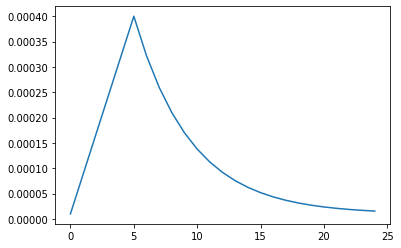

In [8]:

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [9]:
"""LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

    
def scheduler(epoch):
    if epoch < 4:
        return 0.0005
    elif epoch < 8:
        return 0.0002
    elif epoch < 12:
        return 0.0001
    elif epoch < 16:
        return 0.00005
    elif epoch < 20:
        return 0.00002
    else:
        return 0.00001
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [scheduler(x) for x in rng]
plt.plot(rng, y)
#print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))"""

'LR_START = 0.00001\nLR_MAX = 0.00005 * strategy.num_replicas_in_sync\nLR_MIN = 0.00001\nLR_RAMPUP_EPOCHS = 5\nLR_SUSTAIN_EPOCHS = 0\nLR_EXP_DECAY = .8\n\n    \ndef scheduler(epoch):\n    if epoch < 4:\n        return 0.0005\n    elif epoch < 8:\n        return 0.0002\n    elif epoch < 12:\n        return 0.0001\n    elif epoch < 16:\n        return 0.00005\n    elif epoch < 20:\n        return 0.00002\n    else:\n        return 0.00001\n    \nlr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = True)\n\nrng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]\ny = [scheduler(x) for x in rng]\nplt.plot(rng, y)\n#print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))'

In [10]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    image = tf.image.resize(image, [331+30, 331+30], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, size=[331, 331, 3])
    
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) 
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) 
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1)
        
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    return image, label   

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-331x331/train/*.tfrec'), labeled=True)
    # Augmentation
    dataset = dataset.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-331x331/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-331x331/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset
def get_all_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-331x331/train/*.tfrec') + tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-331x331/val/*.tfrec')
, labeled=True)
    # Augmentation
    dataset = dataset.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()
all_training_dataset = get_all_training_dataset()

2023-01-14 23:04:07.048482: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-14 23:04:07.695303: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-14 23:04:07.800035: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-14 23:04:07.866779: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [11]:
## Xception

In [12]:
"""
with strategy.scope():  
    base_model = xception.Xception(
        weights='imagenet',
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        pooling=None
    )
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(104, activation='softmax'))"""

"\nwith strategy.scope():  \n    base_model = xception.Xception(\n        weights='imagenet',\n        input_shape=(*IMAGE_SIZE, 3),\n        include_top=False,\n        pooling=None\n    )\n    base_model.trainable = False\n    \n    model = Sequential()\n    model.add(base_model)\n    model.add(GlobalAveragePooling2D())\n    model.add(BatchNormalization())\n    \n    model.add(Dense(512, activation='relu'))\n    model.add(BatchNormalization())\n    model.add(Dropout(0.2))\n\n    model.add(Dense(104, activation='softmax'))"

## DenseNet

In [13]:
def DenseNet():
    with strategy.scope():
        rnet = DenseNet201(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(104, activation='softmax',dtype='float32')
        ])
    model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
    )
    model.summary()
    return model
    

In [14]:

"""
model.compile(
    optimizer=RMSprop(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)"""

"\nmodel.compile(\n    optimizer=RMSprop(learning_rate=0.0005),\n    loss='sparse_categorical_crossentropy',\n    metrics=['sparse_categorical_accuracy']\n)"

In [15]:
"""model = DenseNet();
history = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          callbacks = [lr_callback],
          validation_steps=VALIDATION_STEPS,
          validation_data=validation_dataset)"""

'model = DenseNet();\nhistory = model.fit(training_dataset, \n          steps_per_epoch=STEPS_PER_EPOCH, \n          epochs=EPOCHS, \n          callbacks = [lr_callback],\n          validation_steps=VALIDATION_STEPS,\n          validation_data=validation_dataset)'

In [16]:
def EfficientNetb7():
    with strategy.scope():
        enet = efn.EfficientNetB7(weights='noisy-student', 
                                include_top=False,
                                pooling='avg',
                                input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        enet.trainable = True
        model2 = tf.keras.Sequential([
            enet,
            tf.keras.layers.Dense(104, activation='softmax',dtype='float32')
        ])
    model2.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    model2.summary()
    return model2
    
    

In [17]:
"""model2 = EfficientNetb7()
history2 = model2.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          callbacks = [lr_callback],
          validation_data=validation_dataset)"""

'model2 = EfficientNetb7()\nhistory2 = model2.fit(training_dataset, \n          steps_per_epoch=STEPS_PER_EPOCH, \n          epochs=EPOCHS, \n          callbacks = [lr_callback],\n          validation_data=validation_dataset)'

## Test Predict

In [18]:
model3 = EfficientNetb7()
history3 = model3.fit(all_training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          callbacks = [lr_callback])

258072576/258068648 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 2560)              64097680  
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________
Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
99/99 [==============================] - 224s 449ms/step - loss: 4.6370 - sparse_categorical_accuracy: 0.0199
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
99/99 [==============================] - 45s 449ms/step - loss: 4.1061 - sparse_categorical_accuracy: 0.1728
Epoch 3/25

Epoch 00003: LearningRateScheduler reduc

In [19]:
model4 = DenseNet();
history = model4.fit(all_training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          callbacks = [lr_callback])

74842112/74836368 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 10, 10, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
99/99 [==============================] - 182s 291ms/step - loss: 4.4818 - sparse_categorical_accuracy: 0.0812
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
99/99 [======================

In [20]:
def run_inference(model):
    test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_images_ds = test_ds.map(lambda image, idnum: image)
    preds = model.predict(test_images_ds,verbose=0, steps=TEST_STEPS)
    return preds

In [21]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Calculating predictions...')
probs1 = run_inference(model3)
probs2 = run_inference(model4)
probabilities = (probs1 + probs2)/2
predictions = np.argmax(probabilities, axis=-1)

print('Generating submission file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

2023-01-14 23:41:52.850493: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-01-14 23:41:53.014651: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Calculating predictions...


2023-01-14 23:42:46.255168: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Generating submission file...


In [22]:
"""plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Model loss')
plt.show()"""

"plt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.legend(['loss', 'val_loss'])\nplt.title('Model loss')\nplt.show()"

In [23]:
"""plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.show()"""

"plt.plot(history.history['sparse_categorical_accuracy'])\nplt.plot(history.history['val_sparse_categorical_accuracy'])\nplt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])\nplt.title('Model accuracy')\nplt.show()"

In [24]:
"""history = model.fit(all_training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          callbacks = [lr_callback])"""

'history = model.fit(all_training_dataset, \n          steps_per_epoch=STEPS_PER_EPOCH, \n          epochs=EPOCHS, \n          callbacks = [lr_callback])'

In [25]:
"""
from tensorflow import keras
Checkpoint=tf.keras.callbacks.ModelCheckpoint(f"Dnet_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
       save_weights_only=True,mode='max')
history = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          callbacks = [lr_callback, Checkpoint, keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2
    )],
          validation_data=validation_dataset)"""

'\nfrom tensorflow import keras\nCheckpoint=tf.keras.callbacks.ModelCheckpoint(f"Dnet_model.h5", monitor=\'val_accuracy\', verbose=1, save_best_only=True,\n       save_weights_only=True,mode=\'max\')\nhistory = model.fit(training_dataset, \n          steps_per_epoch=STEPS_PER_EPOCH, \n          epochs=EPOCHS, \n          callbacks = [lr_callback, Checkpoint, keras.callbacks.EarlyStopping(\n        # Stop training when `val_loss` is no longer improving\n        monitor="val_loss",\n        # "no longer improving" being defined as "no better than 1e-2 less"\n        min_delta=1e-2,\n        # "no longer improving" being further defined as "for at least 2 epochs"\n        patience=2\n    )],\n          validation_data=validation_dataset)'

In [26]:
"""
test_dataset = get_test_dataset(ordered=True)

test_images_dataset = test_dataset.map(lambda image, idnum: image)
probabilities = model.predict(test_images_dataset)
predictions = np.argmax(probabilities, axis=-1)"""

'\ntest_dataset = get_test_dataset(ordered=True)\n\ntest_images_dataset = test_dataset.map(lambda image, idnum: image)\nprobabilities = model.predict(test_images_dataset)\npredictions = np.argmax(probabilities, axis=-1)'

In [27]:
"""test_ids_dataset = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_dataset.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)"""

"test_ids_dataset = test_dataset.map(lambda image, idnum: idnum).unbatch()\ntest_ids = next(iter(test_ids_dataset.batch(NUM_TEST_IMAGES))).numpy().astype('U')\n\n# Write the submission file\nnp.savetxt(\n    'submission.csv',\n    np.rec.fromarrays([test_ids, predictions]),\n    fmt=['%s', '%d'],\n    delimiter=',',\n    header='id,label',\n    comments='',\n)"